# **Group Project**

## **GRA 65602 - Strategic Asset Allocation**

This notebook contains the computations and models used to answer the questions

In [131]:
##
#  This cell cleans the environment
##
rm(list = ls())

In [132]:
##
#  This cell installs the packages for the libraries used
#  Uncomment if necessary
##
# install.packages(c("readxl", "ggplot2", "moments", "matlib", "zoo", "latex2exp"))

In [133]:
##
#  This cell loads the libraries and modules needed
#  @library readxl to read excel files
#  @library moments to compute statistics
#  @library zoo to compute correlations in rolling windows
#  @library latex2exp for formatting text in Latex
#  @library showtext to find fonts for plotting
#  @library systemfonts finds fonts for plotting
#  @module portConstruct with various portfolio construction methods
#  @module portUtility with CRRA utility portfolio construction methods
##
library(readxl)
library(moments)
library(zoo)
library(latex2exp)
library(showtext)
library(systemfonts)
source('portConstruct.R')
source("portUtility.R")

In [134]:
##
#  This cell sets Times New Roman as font for the plots
##
tnr_path <- systemfonts::match_fonts("Times New Roman")$path
font_add("Times New Roman", regular = tnr_path)
showtext_auto()
par(family = "Times New Roman")

In [135]:
##
#  This cell loads and transforms the main data set
#  @dataset data.xlsx file containing the data
#  @return dataset expressed in decimals and formated date 
##
data                                      <- read_excel("data.xlsx", sheet = "csv")
data$Date                                 <- as.Date(data$Date, format = "%Y-%m-%d")
names(data)[names(data) == "Date"]        <- "date"
nonPercentage                             <- c("date", "P/D", "P/E")
data[, !(names(data) %in% nonPercentage)] <- data[, !(names(data) %in% nonPercentage)] / 100

In [136]:
##
#  2.1 This cell gets the data used for the benchmark ptf
##
selectColumns           <- c("date", "us_t1m", "us_infl", "wrld_eq", "wlrd_gbnd")
data7030                <- data[-1, selectColumns]
colnames(data7030)      <- c("date", "rf", "inflation", "equity", "bonds")
head(data7030)

date,rf,inflation,equity,bonds
<date>,<dbl>,<dbl>,<dbl>,<dbl>
1947-01-31,0.0002640758,0.006517691,0.0283385093,0.005332620
1947-02-28,0.0002852513,0.017576318,-0.0003775009,-0.003177945
1947-03-31,0.0002852513,0.000000000,0.0147280967,-0.002681048
1947-04-30,0.0002852187,-0.002272727,0.0078154075,0.002685794
1947-05-31,0.0002852662,0.005922551,-0.0121861152,0.002503421
1947-06-30,0.0002851915,0.006793478,0.0093457944,-0.004443557


[1] " Correlation between equities and bonds, cor(r_equity,r_bonds) = 0.3356"

[1] " Covariance between equities and bonds, cov(r_equity,r_bonds) = 0.00026"

[1] "First(mean) and second(variance) moments of the assets:"

asset,equity,bonds
mean,0.0057,0.0020
sigma,0.0391,0.0200
sigma2,0.0015,0.0004
sharpeRatio,0.1460,0.0977


[1] "-----------------------------------------------------------------------------------------------"

[1] "The infered relative risk aversion of the fund (gamma) is 4.4406"

[1] "-----------------------------------------------------------------------------------------------"

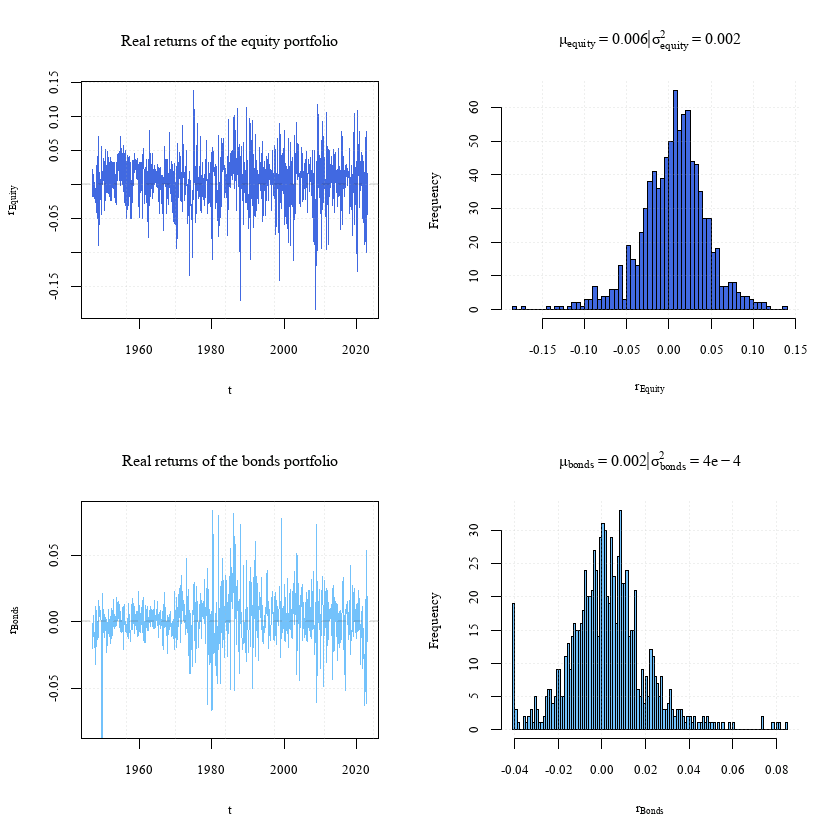

In [137]:
##
#  2.1 This cell infers the relative risk aversion of the fund (gamma)
#  based on the two moments of real returns from equities and bonds
##

# Gets the mean, variance and correlation of equities and bonds
# Uses real returns = (1 + nominal returns) / (1 +  inflation) - 1
rf             <- data7030$rf
rNominalEquity <- data7030$equity
rNominalBonds  <- data7030$bonds 
inflation      <- data7030$inflation
rRealRf        <- (1 + rf)             / (1 + inflation) - 1
rRealEquity    <- (1 + rNominalEquity) / (1 + inflation) - 1
rRealBonds     <- (1 + rNominalBonds)  / (1 + inflation) - 1

# Computes mean, variance, first and second moments of the 2 assets
muRealEquity      <- mean(rRealEquity)
muRealBonds       <- mean(rRealBonds)
varRealEquity     <- var(rRealEquity)
varRealBonds      <- var(rRealBonds)
sdRealEquity      <- sd(rRealEquity)
sdRealBonds       <- sd(rRealBonds)
corEquityBonds    <- cor(rRealEquity, rRealBonds)
covarEquityBonds  <- cov(rRealEquity, rRealBonds)
sharpeRatioEquity <- muRealEquity / sdRealEquity
sharpeRatioBonds  <- muRealBonds  / sdRealBonds

# Print data in a table
meanAssets      <- c(muRealEquity, muRealBonds)
varAssets       <- c(varRealEquity, varRealBonds)
sdAssets        <- c(sdRealEquity, sdRealBonds)
srAssets        <- c(sharpeRatioEquity, sharpeRatioBonds)
moments2Assets  <- data.frame(
                             asset       = c("equity", "bonds"),
                             mean        = round(meanAssets, 4),
                             sigma       = round(sdAssets, 4),
                             sigma2      = round(varAssets, 4),
                             sharpeRatio = round(srAssets, 4)   
                             )
paste(" Correlation between equities and bonds, cor(r_equity,r_bonds) =" ,round(corEquityBonds, 4))
paste(" Covariance between equities and bonds, cov(r_equity,r_bonds) =", round(covarEquityBonds, 5))
paste("First(mean) and second(variance) moments of the assets:")
t(moments2Assets)
paste("-----------------------------------------------------------------------------------------------")

# Compute the inferred risk aversion
# Two fund separation theorem
# gamma = (mu1 - m2) / (w1*(var1 + var2 + 2*cov(1,2)) - (var2 - cov(1,2)))
weightEquity <- 0.70
gamma <- (muRealEquity - muRealBonds) /
         (weightEquity*(varRealEquity + varRealBonds - 2*covarEquityBonds)
          - (varRealBonds - covarEquityBonds))
paste("The infered relative risk aversion of the fund (gamma) is", round(gamma, 4))
paste("-----------------------------------------------------------------------------------------------")

# Plot the moments of the and distributions of the 2 assets
# Plot the distributions of real returns for the assets
date <- data7030$date
par(mfrow = c(2,2), family = "Times New Roman")
colEquity <- "royalblue"
colBonds  <- "#73C2FB"

# Plots the real returns of equity
t1         <- "Real returns of the equity portfolio"
t2         <- TeX(paste("$\\mu_{equity} = ", round(muRealEquity, 3),
                "| \\sigma^2_{equity} = ", round(varRealEquity, 3),"$"
                  ))
x1         <- TeX("$t$")
y1         <- TeX("$r_{Equity}$")
x2         <- TeX("$r_{Equity}$")
colAbline  <- adjustcolor("black", alpha.f = 0.1)
plot(date, rRealEquity, type = "l", main = t1, xlab = x1, ylab = y1, lwd = 1, col = colEquity)
grid(col = adjustcolor("gray70", alpha.f = 0.2), lwd = 1)
abline(h = 0, col = colAbline, lwd = 2, lty = 2)
hist(rRealEquity, breaks = 100, freq = T, main = t2, xlab = x2, col = colEquity)
grid(col = adjustcolor("gray70", alpha.f = 0.2), lwd = 1)

# Plots the real returns of bonds
t1 <- "Real returns of the bonds portfolio"
t2 <- TeX(paste("$\\mu_{bonds} = ", round(muRealBonds, 3),
                "| \\sigma^2_{bonds} = ", round(varRealBonds, 4),"$"
         ))
x1 <- TeX("$t$")
y1 <- TeX("$r_{Bonds}$")
x2 <- TeX("$r_{Bonds}$")
# Truncates lowest 2% values to get a cleaner plot 
qL      <- quantile(rRealBonds, 0.02)
returns <- rRealBonds*(rRealBonds > qL) + qL*(rRealBonds <= qL)
plot(date, rRealBonds, type = "l", main = t1, xlab = x1, ylab = y1,
     ylim = c(quantile(rRealBonds, 0.001), max(rRealBonds)), lwd = 1, col = colBonds)
grid(col = adjustcolor("gray70", alpha.f = 0.2), lwd = 1)
abline(h = 0, col = colAbline, lwd = 2, lty = 2)
hist(returns, breaks = 100, freq = T, main = t2, xlab = x2, col = colBonds)
grid(col = adjustcolor("gray70", alpha.f = 0.2), lwd = 1)

In [138]:
##
#  2.2 This Analyzes improvement in certainty equivalent if investing in rf
##

# Compute the unconstrained optimal portfolio
# Given a relative risk aversion and no risk free rate asset
#assets            <- c("equity", "bonds") 
#dataX             <- data7030[, assets]
rExcessEquity      <- rRealEquity - rRealRf
rExcessBonds       <- rRealBonds  - rRealRf
dataX              <- cbind(rExcessEquity, rExcessBonds)
colnames(dataX)    <- c("equity", "bonds")
mu                 <- colMeans(dataX)
sigma              <- cov(dataX)
gamma              <- gamma
wUncNoRf           <- uncMeanVar_ra(mu, sigma, gamma)
muUncNoRf          <- wUncNoRf %*% mu
sdUncNoRf          <- sqrt(wUncNoRf %*% sigma %*% wUncNoRf)
sharpeRatioUncNoRf <- (wUncNoRf %*% mu) / (sqrt(wUncNoRf %*% sigma %*% wUncNoRf))
ceNoRf             <- 1 + muUncNoRf   - 0.5*gamma*(sdUncNoRf)^2

# Print the portfolio metrics
paste("Unconstrained optimal MV portofolio, given a relative risk aversion (gamma) and no risk free asset (on excess)")
paste("mu =", round(muUncNoRf, 4), "sd =", round(sdUncNoRf, 4), "SR=", round(sharpeRatioUncNoRf, 4), "ce =", round(ceNoRf, 5))
data.frame(round(wUncNoRf, 4))
paste("-----------------------------------------------------------------------------------------------")

# Compute the tangency portfolio introducing risk free asset
rExcessEquity       <- rExcessEquity
rExcessBonds        <- rExcessBonds
dataX               <- data.frame(rExcessEquity, rExcessBonds)
colnames(dataX)     <- c("equity", "bonds")
mu                  <- colMeans(dataX)
sigma               <- cov(dataX)
gamma               <- gamma
wTangency           <- uncTangent(mu, sigma)
muTangency          <- wTangency %*% mu
sdTangency          <- sqrt(wTangency %*% sigma %*% wTangency)
sharpeRatioTangency <- (wTangency %*% mu) / (sqrt(wTangency %*% sigma %*% wTangency))
ceTangency          <- 1 + muTangency  - 0.5*gamma*(sdTangency)^2

# Print the portfolio metrics
paste("Tangency portolio, introducing risk free asset on excess retuns")
paste("mu =", round(muTangency, 4), "sd =", round(sdTangency, 4), "SR=", round(sharpeRatioTangency, 4), "ce =", round(ceTangency, 5))
data.frame(round(wTangency, 4))
paste("-----------------------------------------------------------------------------------------------")

#  Compute the unconstrained mean variance optimization given the risk aversion
#  and risk free asset
optLeverage          <- sharpeRatioTangency / (gamma*sdTangency)
optLeverage          <- as.numeric(optLeverage)
wEquityUncWithRf     <- optLeverage * wTangency["equity"]
wBondsUncWithRf      <- optLeverage * wTangency["bonds"]
wRiskyUncWithRf      <- c(wEquityUncWithRf, wBondsUncWithRf)
wRf                  <- 1 - optLeverage
wUncWithRf           <- c(wRiskyUncWithRf, rf = wRf)
muUncWithRf          <- optLeverage*muTangency + wRf*mean(rRealRf)
sdUncWithRf          <- optLeverage * sdTangency
sharpeRatioUncWithRf <- muUncWithRf / sdUncWithRf
ceWithRf             <- 1 + muUncWithRf - 0.5*gamma*(sdUncWithRf)^2

# Print the portfolio metrics
paste("The optimal leverage SR_Tangency/(gamma*sd_Tangency) is", round(optLeverage, 4))
paste("Unconstrained optimal portfolio, introducing risk free asset and given risk aversion")
paste("mu =", round(muUncWithRf, 4), "sd =", round(sdUncWithRf, 4), "SR=", round(sharpeRatioUncWithRf, 4), "ce =", round(ceWithRf, 5))
data.frame(round(wUncWithRf, 4), row.names = c("equity", "bonds", "rf"))
paste("-----------------------------------------------------------------------------------------------")


# Compare strategies
t <- data.frame(rbind(wUncNoRf, wTangency, wRiskyUncWithRf), mean = c(muUncNoRf, muTangency, muUncWithRf),
               sd = c(sdUncNoRf, sdTangency, sdUncWithRf), SR = c(sharpeRatioUncNoRf, sharpeRatioTangency, sharpeRatioUncWithRf),
               ce = c(ceNoRf, ceTangency, ceWithRf)
               )
paste("Comparison between strategies")
round(t, 4)

[1] "Unconstrained optimal MV portofolio, given a relative risk aversion (gamma) and no risk free asset (on excess)"

[1] "mu = 0.0043 sd = 0.0297 SR= 0.1456 ce = 1.00237"

,round.wUncNoRf..4.
,<dbl>
equity,0.6871
bonds,0.3129


[1] "-----------------------------------------------------------------------------------------------"

[1] "Tangency portolio, introducing risk free asset on excess retuns"

[1] "mu = 0.0039 sd = 0.0264 SR= 0.1465 ce = 1.00232"

,round.wTangency..4.
,<dbl>
equity,0.5672
bonds,0.4328


[1] "-----------------------------------------------------------------------------------------------"

[1] "The optimal leverage SR_Tangency/(gamma*sd_Tangency) is 1.249"

[1] "Unconstrained optimal portfolio, introducing risk free asset and given risk aversion"

[1] "mu = 0.0048 sd = 0.033 SR= 0.1449 ce = 1.00236"

,round.wUncWithRf..4.
,<dbl>
equity,0.7085
bonds,0.5405
rf,-0.2490


[1] "-----------------------------------------------------------------------------------------------"

[1] "Comparison between strategies"

,equity,bonds,mean,sd,SR,ce
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
wUncNoRf,0.6871,0.3129,0.0043,0.0297,0.1456,1.0024
wTangency,0.5672,0.4328,0.0039,0.0264,0.1465,1.0023
wRiskyUncWithRf,0.7085,0.5405,0.0048,0.0330,0.1449,1.0024


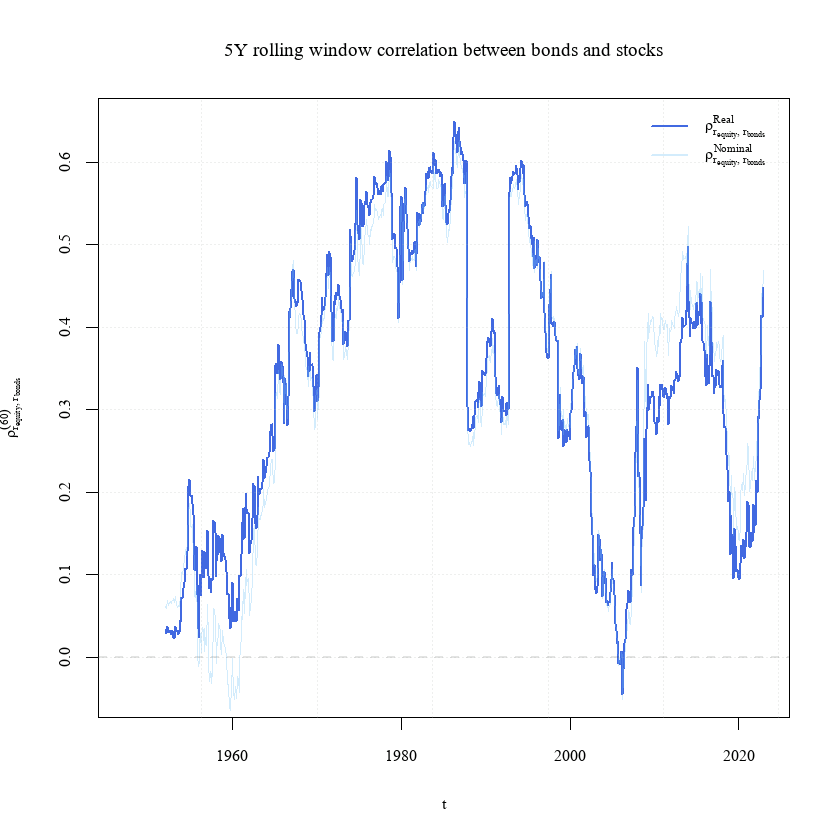

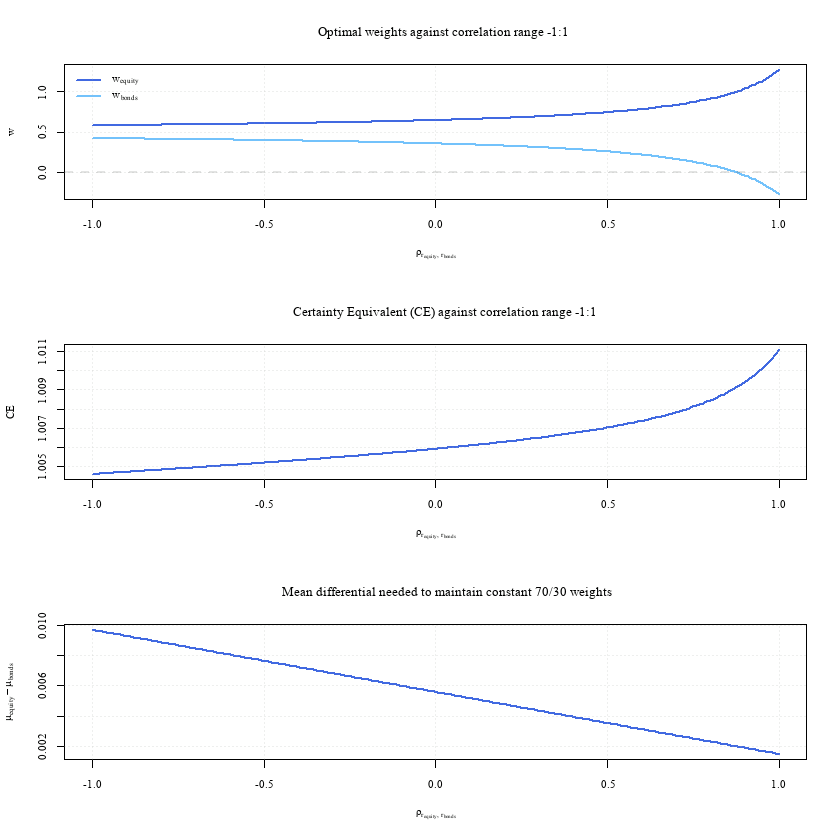

In [139]:
##
#  2.3 Plots 5Y rolling window correlation + finds optimal w and
#  ce over a relevant range of correlations +  meand differencial
#  to maintain constant portfolio weights
##

# Plot 5Y rolling window correlation between bonds and stocks
window                <- 60
xReal                 <- cbind(rRealEquity, rRealBonds)
rollWindowCorrReal    <- rollapply(
                                xReal,
                                width = window,
                                FUN = function(x) cor(x[,1], x[,2]),
                                by = 1,
                                align = "right",
                                fill = NA,
                                by.column = FALSE
                              )
xNominal              <- cbind(rNominalEquity, rNominalBonds)
rollWindowCorrNominal <- rollapply(
                                xNominal,
                                width = window,
                                FUN = function(x) cor(x[,1], x[,2]),
                                by = 1,
                                align = "right",
                                fill = NA,
                                by.column = FALSE
                              )
par(mfrow = c(1,1), family = "Times New Roman")
colReal    <- adjustcolor("royalblue", alpha.f = 1.0)
colNominal <- adjustcolor("#73C2FB", alpha.f = 0.3)
t          <- "5Y rolling window correlation between bonds and stocks"
plot(date, rollWindowCorrReal, type = "l", col = colReal , lwd = 2, main = t,
    xlab = TeX("$t$"), ylab = TeX("$\\rho^{(60)}_{r_{equity},r_{bonds}}$"))
lines(date,rollWindowCorrNominal, col = colNominal)
grid(col = adjustcolor("gray70", alpha.f = 0.2), lwd = 1)
abline(h = 0, col = colAbline, lwd = 2, lty = 2)
legend("topright",
       legend = c(TeX("$\\rho^{Real}_{r_{equity},r_{bonds}}$"), 
       TeX("$\\rho^{Nominal}_{r_{equity},r_{bonds}}$")),
       col = c(colReal, colNominal),
       lwd = 2,
       bg = "white",
       bty = "n")

# Analyzes the optimal portfolio and CE for a relevant range of correlations
# Assume all moments remain constant, uses two fund separation theorem
gamma  <- gamma
mu1    <- muRealEquity
mu2    <- muRealBonds
var1   <- varRealEquity
var2   <- varRealBonds
sigma1 <- sdRealEquity
sigma2 <- sdRealBonds
cor    <- seq(-1.0, 1.0, length.out = 200)

# Solves for the weights and CE
# w1 = {1/gamma * (mu1-mu2) + (s2^2-cov(1,2))} / {s1^2 + s2^2 - 2*cov(1,2)}
# cov(1,2) = corr(1,2)*s1*s2
w1  <- rep(0, length(cor))
w2  <- rep(0, length(cor))
mu  <- rep(0, length(cor))
var <- rep(0, length(cor))
sd  <- rep(0, length(cor))
ce  <- rep(0, length(cor))

for (i in 1:length(cor)) {
  w1[i]  <- (((1/gamma)*(mu1-mu2) + var2 - cor[i]*sigma1*sigma2) /
             (var1 + var2 - 2*cor[i]*sigma1*sigma2)
            )
  w2[i]  <- 1 - w1[i]
  mu[i]  <- w1[i]*mu1 + w2[i]*mu2
  var[i] <- w1[i]^2*var1 + 2*w1[i]*w2[i]*cor[i]*sigma1*sigma2 + w2[i]^2*var2
  sd[i]  <- sqrt(var[i])
  ce[i]  <- 1+mu[i] + 0.5*gamma*sd[i]^2
}

# Plot weights against correlation
par(mfrow = c(3,1))
yMin <- min(w1, w2)
yMax <- max(w1,w2)
t    <- TeX("Optimal weights against correlation range -1:1")
plot(cor, w1, type = "l", col = "royalblue", ylim = c(yMin, yMax), lwd = 2,
     main = t, xlab = TeX("$\\rho_{r_{equity},r_{bonds}}$"), ylab = TeX("$w$"))
lines(cor, w2, col = "#73C2FB", lwd = 2)
legend("topleft",
       legend = c(TeX("$w_{equity}$"), 
       TeX("$w_{bonds}$")),
       col = c("royalblue", "#73C2FB"),
       lwd = 2,
       bg = "white",
       bty = "n")
grid(col = adjustcolor("gray70", alpha.f = 0.2), lwd = 1)
abline(h = 0, col = colAbline, lwd = 2, lty = 2)

# Plot certainty equivalent against correlations
t <- TeX("Certainty Equivalent (CE) against correlation range -1:1")
plot(cor, ce, type = "l", col = "royalblue", lwd = 2, main = t,
     xlab = TeX("$\\rho_{r_{equity},r_{bonds}}$"), ylab = TeX("$CE$"))
grid(col = adjustcolor("gray70", alpha.f = 0.2), lwd = 1)

# How mean differential should change to maintain constant ptf weights
# w1 = 0.70
# mu1 - mu2 = gamma*w1*(s1^2+s2^2-2*cov(1,2) - s2^2 + cov(1,2)
w1          <- 0.70
gamma       <- gamma
mu1         <- mu1
mu2         <- mu2
var1        <- var1
var2        <- var2
sigma1      <- sigma1
sigma2      <- sigma2
cor         <- cor
mu1Minusmu2 <- rep(0, length(cor))
for (i in 1:length(cor)){
  mu1Minusmu2[i] <- (gamma*w1*(var1 + var2 - 2*cor[i]*sigma1*sigma2)
                     - var2 + cor[i]*sigma1*sigma2
                    )
}

# Plot expected return differential to maintain constant weights
t <- TeX("Mean differential needed to maintain constant 70/30 weights")
plot(cor, mu1Minusmu2, type = "l", lwd = 2, col = "royalblue", main = t,
     xlab = TeX("$\\rho_{r_{equity},r_{bonds}}$"), ylab = TeX("$\\mu_{equity}-\\mu_{bonds}$")
    )
grid(col = adjustcolor("gray70", alpha.f = 0.2), lwd = 1)
par(mfrow = c(1,1))

In [140]:
##
#  2.4 Computes optimal weights under CRRA utility lognormal + historical
##

# Compute optimal weights under CRRA utility and lognormal returns
dataX              <- data.frame(equity = rExcessEquity, bonds = rExcessBonds)
gamma              <- gamma
mu                 <- colMeans(dataX)
sigma              <- cov(dataX)
wCrraLog           <- portCRRA(data = dataX, model = "lognorm", gamma = gamma)
muCrraLog          <- as.numeric(wCrraLog %*% mu)
sdCrraLog          <- sqrt(as.numeric(wCrraLog %*% sigma %*% wCrraLog))
sharpeRatioCrraLog <- (wCrraLog %*% mu) / (sqrt(wCrraLog %*% sigma %*% wCrraLog))
ptsGaussHermite    <- gauss.hermite(20)
pGaussHermite      <- ptsGaussHermite[, 2]
rExcessPortfolio   <- muCrraLog + sdCrraLog * ptsGaussHermite[, 1]
rPortfolio         <- 1 + rExcessPortfolio
ceCrraLog          <- (sum(pGaussHermite*rPortfolio^(1-gamma)))^(1/(1-gamma))

paste("Optimal weights under CRRA utility and lognormal returns")
paste("mu =", round(muCrraLog, 4), "sd =", round(sdCrraLog, 4), "SR =", round(sharpeRatioCrraLog, 4), "CE =", round(ceCrraLog, 4))
data.frame(round(wCrraLog,4), row.names = c("equity", "bonds"))
paste("-----------------------------------------------------------------------------------------------")

# Compare with mean variance ptf given a riks aversion and rf (excess returns)
dataX                   <- dataX
gamma                   <- gamma
mu                      <- colMeans(dataX)
sigma                   <- cov(dataX)
wMeanVariance           <- uncMeanVar_ra(mu, sigma, gamma)
muMeanVariance          <- as.numeric(wMeanVariance %*% mu)
sdMeanVariance          <- sqrt(as.numeric(wMeanVariance %*% sigma %*% wMeanVariance))
sdMeanVariance          <- sqrt(wMeanVariance %*% sigma %*% wMeanVariance)
sharpeRatioMeanVariance <- (wMeanVariance %*% mu) / (sqrt(wMeanVariance %*% sigma %*% wMeanVariance))
ceMeanVariance          <- 1 + muMeanVariance - 0.5*gamma*sdMeanVariance^2

paste("Optimal weights under mean variance ptf given a risk aversion and rf (excess returns)")
paste("mu =", round(muMeanVariance, 4), "sd =", round(sdMeanVariance, 4), "SR =", round(sharpeRatioMeanVariance, 4), "CE =", round(ceMeanVariance, 4))
data.frame(round(wMeanVariance, 4), row.names = c("equity", "bonds"))
paste("-----------------------------------------------------------------------------------------------")

# Add historical portfolio excess retuns
dataX                     <- dataX
gamma                     <- gamma
mu                        <- colMeans(dataX)
sigma                     <- cov(dataX)   
wCrraHistorical           <- portCRRA(data = dataX, model = "hist", gamma = gamma)
muCrraHistorical          <- as.numeric(wCrraHistorical %*% mu)
sdCrraHistorical          <- sqrt(as.numeric(wCrraHistorical %*% sigma %*% wCrraHistorical))
sharpeRatioCrraHistorical <- (wCrraHistorical %*% mu) / (sqrt(wCrraHistorical %*% sigma %*% wCrraHistorical))
rExcessPortfolio          <- as.numeric(as.matrix(dataX) %*% wCrraHistorical)
ceCrraHistorical          <- (mean((1+rExcessPortfolio)^(1-gamma)))^(1/(1-gamma))

paste("Optimal weights under CRRA utility and historical simulation")
paste("mu =", round(muCrraHistorical, 4), "sd =", round(sdCrraHistorical, 4), "SR =", round(sharpeRatioCrraHistorical, 4), "CE =", round(ceCrraHistorical, 4))
data.frame(round(wCrraHistorical, 5), row.names = c("equity", "bonds"))

# Compare strategies
t <- data.frame(rbind(wCrraLog, wMeanVariance, wCrraHistorical), mean = c(muCrraLog, muMeanVariance, muCrraHistorical),
               sd = c(sdCrraLog, sdMeanVariance, sdCrraHistorical), SR = c(sharpeRatioCrraLog, sharpeRatioMeanVariance, sharpeRatioCrraHistorical),
               ce = c(ceCrraLog, ceMeanVariance, ceCrraHistorical)
               )
paste("Comparison between strategies")
round(t, 4)

[1] "Optimal weights under CRRA utility and lognormal returns"

[1] "mu = 0.0043 sd = 0.0293 SR = 0.1457 CE = 1.0024"

,round.wCrraLog..4.
,<dbl>
equity,0.6756
bonds,0.3240


[1] "-----------------------------------------------------------------------------------------------"

[1] "Optimal weights under mean variance ptf given a risk aversion and rf (excess returns)"

[1] "mu = 0.0043 sd = 0.0297 SR = 0.1456 CE = 1.0024"

,round.wMeanVariance..4.
,<dbl>
equity,0.6871
bonds,0.3129


[1] "-----------------------------------------------------------------------------------------------"

[1] "Optimal weights under CRRA utility and historical simulation"

[1] "mu = 0.0042 sd = 0.0288 SR = 0.146 CE = 1.0023"

,round.wCrraHistorical..5.
,<dbl>
equity,0.65715
bonds,0.34261


[1] "Comparison between strategies"

,equity,bonds,mean,sd,SR,ce
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
wCrraLog,0.6756,0.3240,0.0043,0.0293,0.1457,1.0024
wMeanVariance,0.6871,0.3129,0.0043,0.0297,0.1456,1.0024
wCrraHistorical,0.6572,0.3426,0.0042,0.0288,0.1460,1.0023


[1] "Optimal weights under MV portfolio without the rf asset"

[1] "mu = 0.0044 sd = 0.0294 SR = 0.1509 CE = 1.0025"

,round.wMeanVarianceNoRf..4.
,<dbl>
developed,-0.2180
emerging,0.1561
equity,0.7604
bonds,0.5497
bondsExUS,-0.2482


[1] "-----------------------------------------------------------------------------------------------"

[1] "Optimal weights under the tangenct portfolio withe the rf asset"

[1] "mu = 0.0037 sd = 0.0241 SR = 0.1533 CE = 1.00241"

,round.wTangencyRf..4.
,<dbl>
developed,-0.1755
emerging,0.1245
equity,0.5718
bonds,0.9275
bondsExUS,-0.4483


[1] "-----------------------------------------------------------------------------------------------"

,developed,emerging,equity,bonds,bondsExUS,mean,sd,SR,ce
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
wBenchmark,0.000,0.0000,0.7000,0.3000,0.0000,0.0044,0.0300,0.1454,1.0024
wMeanVarianceNoRf,-0.218,0.1561,0.7604,0.5497,-0.2482,0.0044,0.0294,0.1509,1.0025


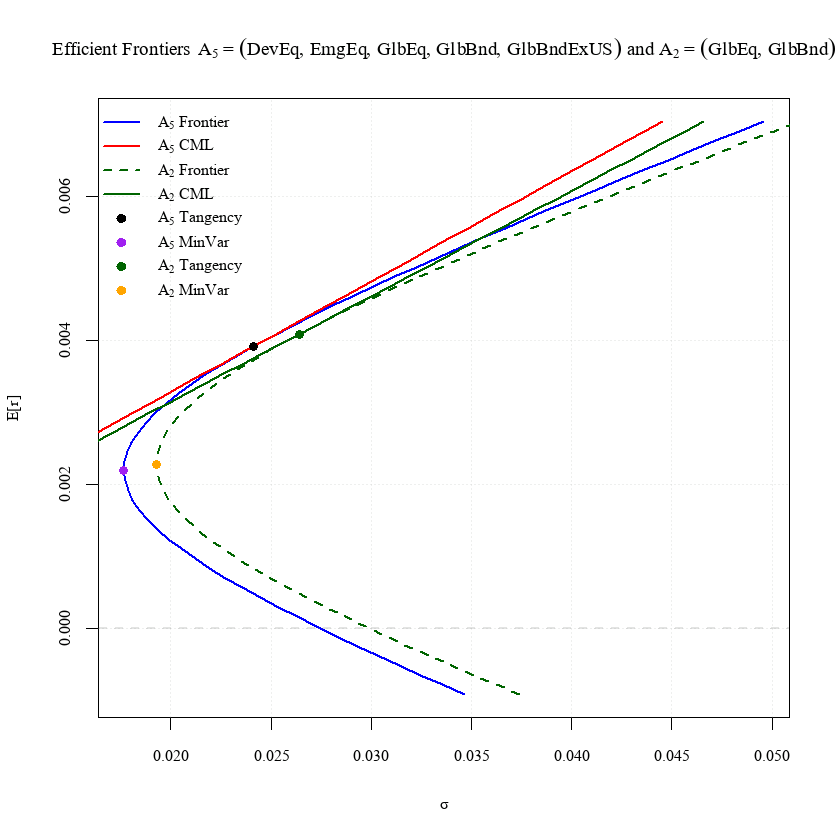

In [141]:
##
#  2.5 Mean variance analysis incorporating more than two asset classes
##

# Gets the selected indices to be incorporated
# dvlp_eq	 GFD Indices Developed World x/North America Return Index
# emrg_eq	 GFD Indices Emerging Markets Return Index
# wrld_eq	 GFD Indices All World Return Index
# wrld_gbnd	 GFD Indices World Government Bond GDP-weighted Return Index
# wrldx_gbnd GFD Indices World x/USA Countries Government Bond GDP-weighted Return Index
assets          <- c("dvlp_eq", "emrg_eq", "wrld_eq", "wlrd_gbnd", "wrldx_gbnd")
dataX           <- data[-1, assets]
colnames(dataX) <- c("developed", "emerging", "equity", "bonds", "bondsExUS")
rRealRf         <- rRealRf
inflation       <- inflation
dataReal        <- (1 + dataX) / (1 + inflation) - 1 
dataExcess      <- dataReal - rRealRf


# Compute MV portfolio without the rf asset,
mu                          <- colMeans(dataExcess)
sigma                       <- cov(dataExcess)
gamma                       <- gamma
wMeanVarianceNoRf           <- uncMeanVar_ra(mu, sigma, gamma)
muMeanVarianceNoRf          <- as.numeric(wMeanVarianceNoRf %*% mu)
sdMeanVarianceNoRf          <- sqrt(as.numeric(wMeanVarianceNoRf %*% sigma %*% wMeanVarianceNoRf))
sharpeRatioMeanVarianceNoRf <- (wMeanVarianceNoRf %*% mu) / (sqrt(wMeanVarianceNoRf %*% sigma %*% wMeanVarianceNoRf))
ceMeanVarianceNoRf          <- 1 + muMeanVarianceNoRf - 0.5*gamma*sdMeanVarianceNoRf^2

paste("Optimal weights under MV portfolio without the rf asset")
paste("mu =", round(muMeanVarianceNoRf, 4), "sd =", round(sdMeanVarianceNoRf, 4), "SR =", round(sharpeRatioMeanVarianceNoRf, 4), "CE =", round(ceMeanVarianceNoRf, 4))
data.frame(round(wMeanVarianceNoRf, 4), row.names = c("developed", "emerging", "equity", "bonds", "bondsExUS"))
paste("-----------------------------------------------------------------------------------------------")

# Compute the tangenct portfolio withe the rf asset
mu                          <- colMeans(dataExcess)
sigma                       <- cov(dataExcess)
gamma                       <- gamma
wTangencyRf                 <- uncTangent(mu, sigma)
muTangencyRf                <- as.numeric(wTangencyRf %*% mu)
sdTangencyRf                <- sqrt(as.numeric(wTangencyRf %*% sigma %*% wTangencyRf))
sharpeRatioTangencyRf       <- (wTangencyRf %*% mu) / (sqrt(wTangencyRf %*% sigma %*% wTangencyRf))
ceTangencyRf                <- 1 + muTangencyRf - 0.5*gamma*sdTangencyRf^2

paste("Optimal weights under the tangenct portfolio withe the rf asset")
paste("mu =", round(muTangencyRf, 4), "sd =", round(sdTangencyRf, 4), "SR =", round(sharpeRatioTangencyRf, 4), "CE =", round(ceTangencyRf, 5))
data.frame(round(wTangencyRf, 4), row.names = c("developed", "emerging", "equity", "bonds", "bondsExUS"))
paste("-----------------------------------------------------------------------------------------------")

# Plot the efficient frontier without rf
mu               <- colMeans(dataExcess)
sigma            <- cov(dataExcess)
rf               <- mean(rRealRf)

# Start with the 5 assets ptf
wTangencyRf      <- wTangencyRf
muTangencyRf     <- muTangencyRf
sdTangencyRf     <- sdTangencyRf

wMinVariance     <- portMinVar(sigma)
muMinVariance    <- as.numeric(t(wMinVariance) %*% mu)
sdMinVariance    <- sqrt(as.numeric(t(wMinVariance) %*% sigma %*% wMinVariance))

rangeMu <- seq(from = -0.2 * max(mu),
               to   =  1.2 * max(mu),
               length.out = 60)

M <- matrix(NA, nrow = length(rangeMu), ncol = 4)

i <- 1
for(muTarget in rangeMu){

    wPtf         <- uncMeanVar_mu(mu, sigma, muTarget)
    muNoRf       <- rf + as.numeric(t(wPtf) %*% mu)
    sdNoRf       <- sqrt(as.numeric(t(wPtf) %*% sigma %*% wPtf))

    leverage     <- muTarget / muTangencyRf
    muRfLine     <- rf + muTarget
    sdRfLine     <- leverage * sdTangencyRf

    M[i, ]       <- c(muNoRf, sdNoRf, muRfLine, sdRfLine)
    i <- i + 1
}

# Continue with equity and bonds ptf
dataTwoAssets  <- dataExcess[, c("equity", "bonds")]
muTwoAssets    <- colMeans(dataTwoAssets)
sigmaTwoAssets <- cov(dataTwoAssets)

wTangencyTwo   <- uncTangent(muTwoAssets, sigmaTwoAssets)
muTangencyTwo  <- as.numeric(t(wTangencyTwo) %*% muTwoAssets)
sdTangencyTwo  <- sqrt(as.numeric(t(wTangencyTwo) %*% sigmaTwoAssets %*% wTangencyTwo))

wMinVarTwo     <- portMinVar(sigmaTwoAssets)
muMinVarTwo    <- as.numeric(t(wMinVarTwo) %*% muTwoAssets)
sdMinVarTwo    <- sqrt(as.numeric(t(wMinVarTwo) %*% sigmaTwoAssets %*% wMinVarTwo))

TTwo <- matrix(NA, nrow = length(rangeMu), ncol = 4)

i <- 1
for(muTarget in rangeMu){

    wTwo        <- uncMeanVar_mu(muTwoAssets, sigmaTwoAssets, muTarget)
    muNoRfTwo   <- rf + as.numeric(t(wTwo) %*% muTwoAssets)
    sdNoRfTwo   <- sqrt(as.numeric(t(wTwo) %*% sigmaTwoAssets %*% wTwo))

    leverageTwo <- muTarget / muTangencyTwo
    muRfTwo     <- rf + muTarget
    sdRfTwo     <- leverageTwo * sdTangencyTwo

    TTwo[i, ]   <- c(muNoRfTwo, sdNoRfTwo, muRfTwo, sdRfTwo)
    i <- i + 1
}

# Plot
par(mfrow = c(1,1), family = "Times New Roman")
plot(M[,2], M[,1], type="l", lwd=2, col="blue",
     xlab= TeX("$\\sigma$"), ylab= TeX("$\\E[r]$"),
     main= TeX("Efficient Frontiers $A_{5}=(DevEq,EmgEq,GlbEq,GlbBnd,GlbBndExUS)$ and $A_2=(GlbEq,GlbBnd)$"))

lines(M[,4], M[,3], col="red", lwd=2)
lines(TTwo[,2], TTwo[,1], col="darkgreen", lwd=2, lty=2)
lines(TTwo[,4], TTwo[,3], col="darkgreen", lwd=2, lty=1)

points(sdTangencyRf,  rf + muTangencyRf,  pch=19, col="black")
points(sdMinVariance, rf + muMinVariance, pch=19, col="purple")
points(sdTangencyTwo, rf + muTangencyTwo, pch=19, col="darkgreen")
points(sdMinVarTwo,   rf + muMinVarTwo,   pch=19, col="orange")

grid(col = adjustcolor("gray70", alpha.f = 0.2), lwd = 1)
abline(h = 0, col = colAbline, lwd = 2, lty = 2)

legend("topleft",
       legend=c(TeX("$A_{5}$ Frontier"), TeX("$A_{5}$ CML"),
                TeX("$A_{2}$ Frontier"), TeX("$A_{2}$ CML"),
                TeX("$A_{5}$ Tangency"), TeX("$A_{5}$ MinVar"),
                TeX("$A_{2}$ Tangency"), TeX("$A_{2}$ MinVar")),
       col=c("blue","red","darkgreen","darkgreen","black","purple","darkgreen","orange"),
       lty=c(1,1,2,1,NA,NA,NA,NA),
       pch=c(NA,NA,NA,NA,19,19,19,19),
       lwd=2, bty = "n")

# Compare against benchmark strategy
wBenchmark           <- c(0.0, 0.0, 0.70, 0.30, 0)   
mu                   <- colMeans(dataExcess)
sigma                <- cov(dataExcess)
muBenchmark          <- as.numeric(wBenchmark %*% mu)
sdBenchmark          <- sqrt(as.numeric(t(wBenchmark) %*% sigma %*% wBenchmark))
sharpeRatioBenchmark <- muBenchmark / sdBenchmark
ceBenchmark          <- 1 + muBenchmark - 0.5 * gamma * sdBenchmark^2


t <- data.frame(rbind(wBenchmark, wMeanVarianceNoRf), mean = c(muBenchmark, muMeanVarianceNoRf),
               sd = c(sdBenchmark, sdMeanVarianceNoRf), SR = c(sharpeRatioBenchmark, sharpeRatioMeanVarianceNoRf),
               ce = c(ceBenchmark, ceMeanVarianceNoRf)
               )
round(t, 4)

In [142]:
##
#  3.0 Add NTW into account (i) no leverage or ptf constraints
#  and (ii) restricted of leverage or short-selling
##

# Get the right time series for the lenght of oil as NTW returns
variables         <- c("date","us_t1m", "us_infl", "oil", "wrld_eq", "wlrd_gbnd")
dataNtw           <- na.omit(data[, variables])
colnames(dataNtw) <- c("date", "rf", "inflation", "oil", "equity", "bonds")
dataNtw$rf        <- (1 + dataNtw$rf)     / (1 + dataNtw$inflation) - 1
dataNtw$equity    <- (1 + dataNtw$equity) / (1 + dataNtw$inflation) - 1
dataNtw$equity    <- dataNtw$equity - dataNtw$rf 
dataNtw$bonds     <- (1 + dataNtw$bonds) / (1 + dataNtw$inflation) - 1
dataNtw$bonds     <- dataNtw$bonds - dataNtw$rf

# Compute the unconstraint ptf with NTW
assets            <- c("equity", "bonds")
dataX             <- dataNtw[, assets]
gamma             <- gamma
rNtw              <- dataNtw$oil
mu                <- colMeans(dataX)
sigma             <- cov(dataX)
sigmaN            <- cov(rNtw, dataX)
sigmaN            <- matrix(as.numeric(sigmaN), ncol = 1)
betaN             <- inv(sigma) %*% as.numeric(sigmaN)
y                 <- 0.25/1
xMyopicUnc        <- (1/(1 - y)) * uncMeanVar_ra(mu, sigma, gamma)
xHedgeUnc         <- (y / (1 - y)) * betaN
xUnc              <- as.numeric(xMyopicUnc - xHedgeUnc)
xUnc              <- c(equity = xUnc[1], bonds = xUnc[2])
muUnc             <- y*mean(rNtw) + (1-y)*(mean(dataNtw$rf) + t(xUnc)%*%mu)
varUnc            <- y^2 * sd(rNtw)^2 + (1-y)^2 * t(xUnc)%*%sigma%*%xUnc + 2*y*(1-y)*t(xUnc)%*%sigmaN
sdUnc             <- sqrt(varUnc)
sharpeRatioUnc    <- muUnc / sdUnc
ceUnc             <- 1 + muUnc - 0.5*gamma*sdUnc^2

paste("The beta of equity is", round(betaN[1], 4), "and beta of bonds is", round(betaN[2], 4))
paste("-----------------------------------------------------------------------------------------------")

paste("Optimal weights under unconstrained ptf based on myopic and NTW")
paste("mu =", round(muUnc, 4), "sd =", round(sdUnc, 4), "SR =", round(sharpeRatioUnc, 4), "CE =", round(ceUnc, 4))
data.frame(round(xUnc, 4), row.names = c("equity", "bonds"))
paste("-----------------------------------------------------------------------------------------------")

# Compute the constrained ptf with NTW
dataX             <- dataX
gamma             <- gamma
rNtw              <- rNtw
mu                <- mu
sigma             <- sigma
sigmaN            <- sigmaN
betaN             <- betaN
y                 <- 0.25/1
xMyopicCon        <- (1/(1 - y)) * conMeanVar(mu, sigma, target="ra", t_val=gamma, lower=0, upper=1)
xHedgeCon         <- (y / (1 - y)) * betaN
xCon              <- as.numeric(xMyopicCon - xHedgeCon)
xCon              <- c(equity = xCon[1], bonds = xCon[2])
xCon              <- pmax(xCon, 0)
xCon              <- xCon / sum(xCon)
muCon             <- y*mean(rNtw) + (1-y)*(mean(dataNtw$rf) + t(xCon)%*%mu)
varCon            <- y^2 * sd(rNtw)^2 + (1-y)^2 * t(xCon)%*%sigma%*%xCon + 2*y*(1-y)*t(xCon)%*%sigmaN
sdCon             <- sqrt(varCon)
sharpeRatioCon    <- muCon / sdCon
ceCon             <- 1 + muCon - 0.5*gamma*sdCon^2

paste("Optimal weights under constrained ptf based on myopic and NTW")
paste("mu =", round(muCon, 4), "sd =", round(sdCon, 4), "SR =", round(sharpeRatioCon, 4), "CE =", round(ceCon, 4))
data.frame(round(xCon, 4), row.names = c("equity", "bonds"))
paste("-----------------------------------------------------------------------------------------------")

# Compare strategies
wBenchmark <- c(equity = wBenchmark[3], bonds = wBenchmark[4])
t <- data.frame(rbind(wBenchmark, xUnc, xCon), mean = c(muBenchmark, muUnc, muCon),
               sd = c(sdBenchmark, sdUnc, sdCon), SR = c(sharpeRatioBenchmark, sharpeRatioUnc, sharpeRatioCon),
               ce = c(ceBenchmark, ceUnc, ceCon)
               )
paste("Comparison between strategies")
round(t, 4)

[1] "The beta of equity is 0.4362 and beta of bonds is -0.4979"

[1] "-----------------------------------------------------------------------------------------------"

[1] "Optimal weights under unconstrained ptf based on myopic and NTW"

[1] "mu = 0.006 sd = 0.0336 SR = 0.1777 CE = 1.0035"

,round.xUnc..4.
,<dbl>
equity,0.2502
bonds,1.1038


[1] "-----------------------------------------------------------------------------------------------"

[1] "Optimal weights under constrained ptf based on myopic and NTW"

[1] "mu = 0.0051 sd = 0.03 SR = 0.1707 CE = 1.0031"

,round.xCon..4.
,<dbl>
equity,0.1847
bonds,0.8153


[1] "-----------------------------------------------------------------------------------------------"

[1] "Comparison between strategies"

,equity,bonds,mean,sd,SR,ce
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
wBenchmark,0.7000,0.3000,0.0044,0.0300,0.1454,1.0024
xUnc,0.2502,1.1038,0.0060,0.0336,0.1777,1.0035
xCon,0.1847,0.8153,0.0051,0.0300,0.1707,1.0031


[1] "The average turnover (rebalancing) for the whole 20Y (240 month) period is 34"

[1] "-----------------------------------------------------------------------------------------------"

[1] "Statistics for the rebalancing strategy"

,round.statsRebal..4.
,<dbl>
Mean,2.5533
Median,2.2950
Std,1.2145
Skew,1.4450
Kurt,6.3721
CE,1.6431


[1] "Statistics for the buy and hold"

,round.statsBuyHold..4.
,<dbl>
Mean,2.6062
Median,2.2494
Std,1.4238
Skew,2.2268
Kurt,12.4677
CE,1.6473


[1] "-----------------------------------------------------------------------------------------------"

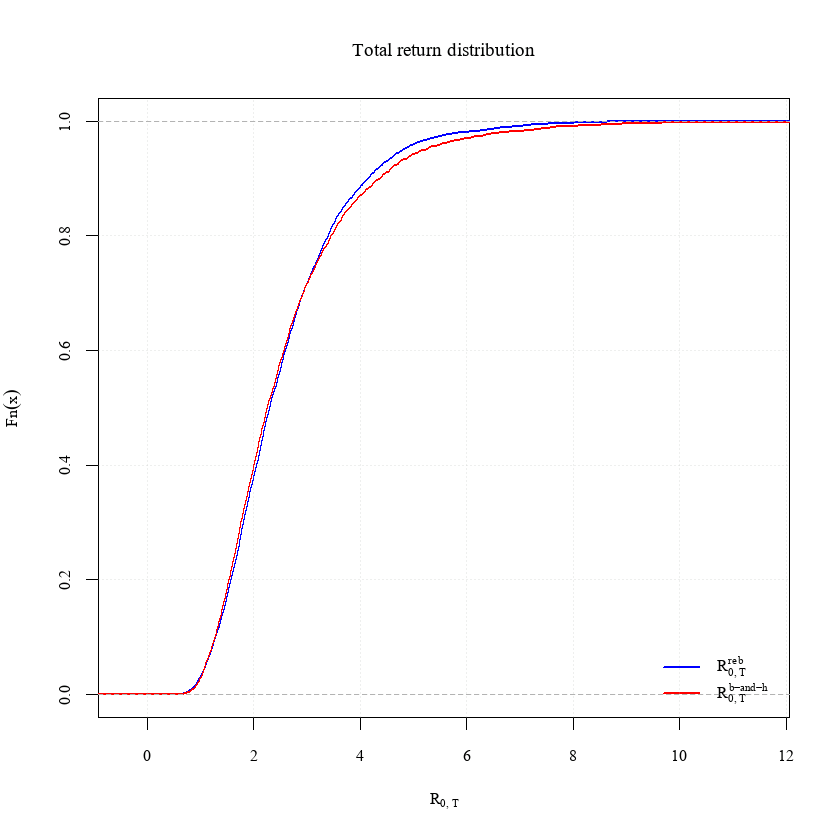

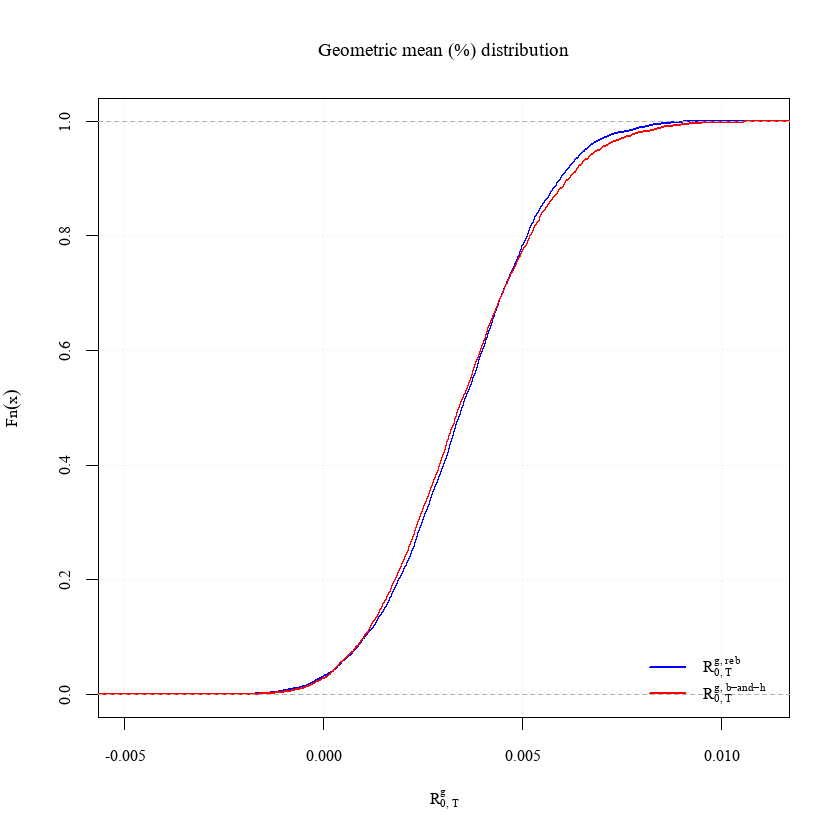

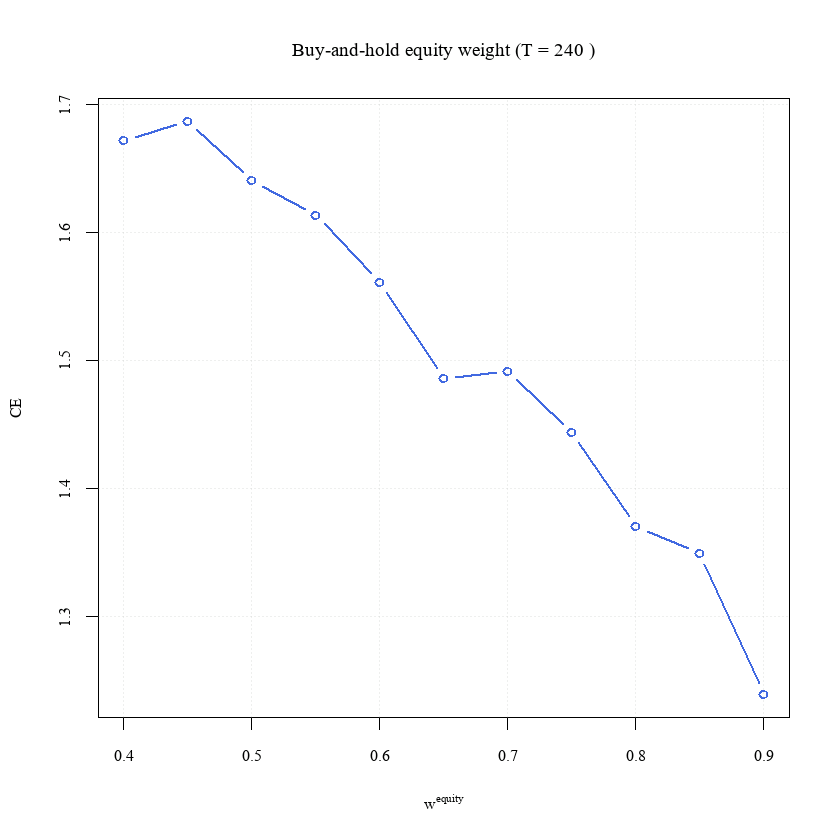

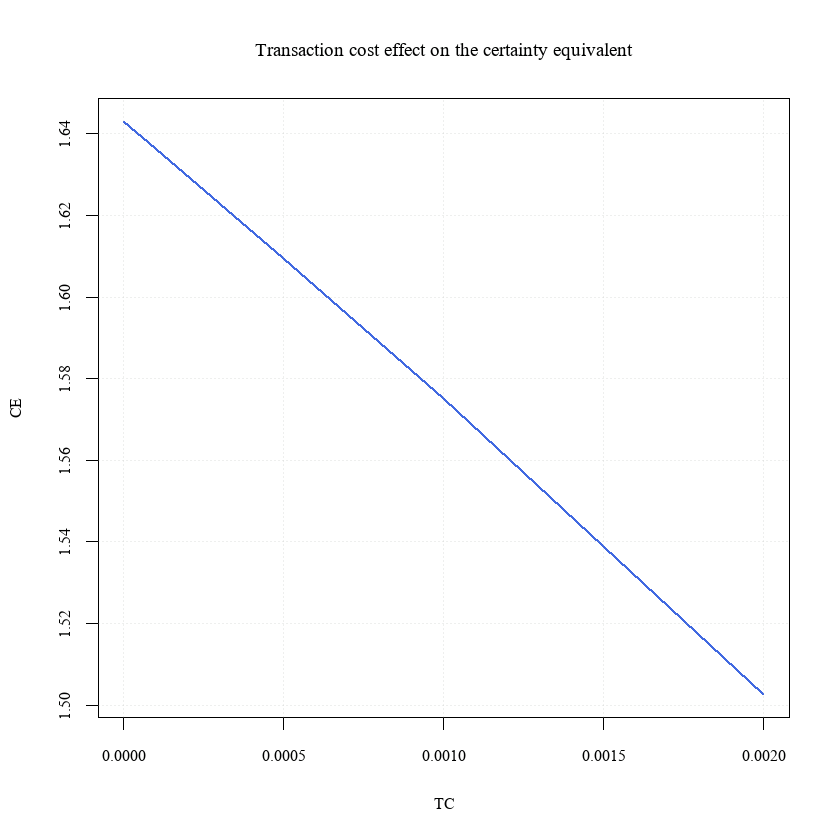

In [143]:
##
#  4.1 Assumes constant IOS and log-normal returns
#  Analyzes rebalancing and buy and hold strategies over 20 years and TC
##

# Converts to log-normal parameters, uses tangecy ptf (equity,bonds)
mu        <- mu
sigma     <- sigma
wTangency <- wTangency
T         <- 240        # 20 years * 12 months
nPaths    <- 5000       # number of simulations
gamma     <- gamma

# Log-normal parameters for ONE MONTH (lecture 4)
muLog    <- mu - 0.5 * diag(sigma)
sigmaLog <- sigma

# Gauss–Hermite quadrature for ONE-MONTH returns
pts <- mgauss.hermite(
    n     = 10,
    mu    = muLog,
    sigma = sigmaLog,
    prune = 0.2
)

oneMonthReturns <- exp(pts$points) - 1
ghWeights       <- pts$weights

# Return path generator for 240-month simulation
sampleReturns <- function() {
    idx <- sample(seq_len(nrow(oneMonthReturns)), size=T,
                  replace=TRUE, prob=ghWeights)
    oneMonthReturns[idx, ]
}

# Dynamic simulation: Rebalancing vs Buy-and-Hold + turnover
wealthRebal   <- numeric(nPaths)
wealthBuyHold <- numeric(nPaths)
turnoverTotal <- numeric(nPaths)

for (sim in 1:nPaths){

    wealthRb <- 1
    wealthBh <- 1
    wBh      <- wTangency
    turnSim  <- 0

    returnPath <- sampleReturns()

    for (t in 1:T){

        Rt <- returnPath[t, ]

        # Rebalancing (constant mix)
        wealthRb <- wealthRb * (1 + sum(wTangency * Rt))

        # Buy-and-hold (drifting weights)
        wealthBh <- wealthBh * (1 + sum(wBh * Rt))

        # Drifted weights
        wNew <- wBh * (1 + Rt)
        wNew <- wNew / sum(wNew)

        # Turnover needed to rebalance into tangency portfolio
        turnoverT <- sum(abs(wTangency - wNew))
        turnSim <- turnSim + turnoverT

        # Update BH weights
        wBh <- wNew
    }

    wealthRebal[sim]   <- wealthRb
    wealthBuyHold[sim] <- wealthBh
    turnoverTotal[sim] <- turnSim
}

# Statistics Function (Mean, Median, SD, Skew, Kurt, CE)
computeStats <- function(w){

    ce <- if (gamma == 1){
        exp(mean(log(w)))
    } else {
        (mean(w^(1 - gamma)))^(1 / (1 - gamma))
    }

    return(c(
        Mean   = mean(w),
        Median = median(w),
        Std    = sd(w),
        Skew   = skewness(w),
        Kurt   = kurtosis(w),
        CE     = ce
    ))
}

statsRebal   <- computeStats(wealthRebal)
statsBuyHold <- computeStats(wealthBuyHold)

paste("The average turnover (rebalancing) for the whole 20Y (240 month) period is", round(mean(turnoverTotal, 5)))
paste("-----------------------------------------------------------------------------------------------")
paste("Statistics for the rebalancing strategy")
data.frame(round(statsRebal, 4))
paste("Statistics for the buy and hold")
data.frame(round(statsBuyHold, 4))
paste("-----------------------------------------------------------------------------------------------")

# Plot CDF of TOTAL RETURNS
par(mfrow=c(1,1), family = "Times New Roman")

plot(ecdf(wealthRebal),
     col="blue", lwd=2,
     main="Total return distribution",
     xlab=TeX("$R_{0,T}$"), ylab= TeX("$Fn(x)$"))

lines(ecdf(wealthBuyHold),
      col="red", lwd=2)

legend("bottomright",
       legend=c(TeX("$R^{reb}_{0,T}$"), TeX("$R^{b-and-h}_{0,T}$")),
       col=c("blue","red"), lwd=2, bty="n")

grid(col = adjustcolor("gray70", alpha.f = 0.2), lwd = 1)


# Plot CDF of GEOMETRIC MEAN RETURNS
geoMeanRebal   <- wealthRebal^(1/T) - 1
geoMeanBuyHold <- wealthBuyHold^(1/T) - 1

plot(ecdf(geoMeanRebal),
     col="blue", lwd=2,
     main="Geometric mean (%) distribution",
     xlab=TeX("$R^{g}_{0,T}$"),
     ylab= TeX("$Fn(x)$"))

lines(ecdf(geoMeanBuyHold),
      col="red", lwd=2)

legend("bottomright",
       legend=c(TeX("$R^{g,reb}_{0,T}$"), TeX("$R^{g,b-and-h}_{0,T}$")),
       col=c("blue","red"), lwd=2, bty="n")

grid(col = adjustcolor("gray70", alpha.f = 0.2), lwd = 1)

# Plot CE Curve vs Equity Weight
computeCE <- function(w){
    if (gamma == 1){
        return(exp(mean(log(w))))
    } else {
        return((mean(w^(1 - gamma)))^(1/(1 - gamma)))
    }
}

equityWeightGrid <- seq(0.40, 0.90, by=0.05)
ceValues         <- numeric(length(equityWeightGrid))

for (i in seq_along(equityWeightGrid)){

    wEquities <- equityWeightGrid[i]
    wBonds    <- 1 - wEquities

    wealthTemp <- numeric(nPaths)

    for (sim in 1:nPaths){

        # Rt is 240×2 monthly returns for: column 1 = equities, column 2 = bonds
        Rt <- sampleReturns()

        # monthly portfolio return = wEquities * equities + wBonds * bonds
        monthlyPortfolioReturns <- Rt[,1] * wEquities + Rt[,2] * wBonds

        # terminal wealth under buy-and-hold
        wealthTemp[sim] <- prod(1 + monthlyPortfolioReturns)
    }

    ceValues[i] <- computeCE(wealthTemp)
}

plot(equityWeightGrid, ceValues,
     type="b", pch=1, lwd=2, col="royalblue",
     main=paste("Buy-and-hold equity weight (T =", T, ")"),
     xlab= TeX("$w^{equity}$"),
     ylab=TeX("$CE$"))
grid(col = adjustcolor("gray70", alpha.f = 0.2), lwd = 1)

# Plot Transaction Cost Analysis (range of TC values)
tcRange <- c(0, 0.0001, 0.0005, 0.001, 0.002) # 0–20 bps
tcResults <- data.frame(
    tcLevel = tcRange,
    ceRebal = NA_real_
)

for (i in seq_along(tcRange)) {
    tc <- tcRange[i]
    adjWealth <- wealthRebal * (1 - tc * turnoverTotal)
    tcResults$ceRebal[i] <- computeStats(adjWealth)["CE"]
}

t <- "Transaction cost effect on the certainty equivalent"
plot(tcResults$tcLevel, tcResults$ceRebal, type = "l", col = "royalblue", main = t,
     xlab = TeX("$TC$"), ylab = TeX("$CE$"), lwd  = 2
    )
grid(col = adjustcolor("gray70", alpha.f = 0.2), lwd = 1)